## From EDA

In [1]:
from skimage import io as skio
import pandas as pd
import matplotlib.pyplot as plt
from skimage import filters,morphology
import glob, os
import cv2
import numpy as np
from scipy.ndimage import label
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
def image_transform(images):
    images = skio.imread(images,as_gray=True)
    img = filters.gaussian(images, sigma=3.0)
    img = filters.sobel(img)
    dark_spots = np.array((img > 2/255).nonzero())
    bool_mask = np.zeros(img.shape, dtype=np.bool)
    bool_mask[tuple(dark_spots)] = 1.
    seed_mask, num_seeds = label(bool_mask)
    ws = morphology.watershed(img, seed_mask)
        # do the watershed on all 3 layers
    images=ws*images
    images= cv2.resize(images,(256,256), interpolation = cv2.INTER_CUBIC)
    return images.flatten()

In [3]:
len(glob.glob('imgs\\train\\*\\*.jpg'))

22424

In [4]:
directories=np.array(glob.glob('imgs\\train\\*\\*.jpg'))

In [5]:
# checking that the directories match
glob.glob('imgs\\train\\*\\*.jpg')[:10]

['imgs\\train\\c0\\img_100026.jpg',
 'imgs\\train\\c0\\img_10003.jpg',
 'imgs\\train\\c0\\img_100050.jpg',
 'imgs\\train\\c0\\img_100074.jpg',
 'imgs\\train\\c0\\img_10012.jpg',
 'imgs\\train\\c0\\img_100145.jpg',
 'imgs\\train\\c0\\img_100191.jpg',
 'imgs\\train\\c0\\img_100257.jpg',
 'imgs\\train\\c0\\img_100312.jpg',
 'imgs\\train\\c0\\img_100337.jpg']

In [6]:
glob.glob('imgs\\train\\*\\*.jpg')[-10:]

['imgs\\train\\c9\\img_99601.jpg',
 'imgs\\train\\c9\\img_99653.jpg',
 'imgs\\train\\c9\\img_99692.jpg',
 'imgs\\train\\c9\\img_99733.jpg',
 'imgs\\train\\c9\\img_99740.jpg',
 'imgs\\train\\c9\\img_99761.jpg',
 'imgs\\train\\c9\\img_99801.jpg',
 'imgs\\train\\c9\\img_99927.jpg',
 'imgs\\train\\c9\\img_9993.jpg',
 'imgs\\train\\c9\\img_99949.jpg']

In [7]:
image_list=pd.read_csv('driver_imgs_list.csv')
image_list.sort_values(['classname','img'])

,subject,classname,img
2458,p015,c0,img_100026.jpg
5693,p022,c0,img_10003.jpg
5712,p022,c0,img_100050.jpg
15339,p051,c0,img_100074.jpg
9,p002,c0,img_10012.jpg
...,...,...,...
2396,p014,c9,img_99761.jpg
15316,p050,c9,img_99801.jpg
12676,p045,c9,img_99927.jpg
11947,p042,c9,img_9993.jpg


In [8]:
y=image_list.sort_values(['classname','img'])['classname']

In [9]:
X=glob.glob('imgs\\train\\*\\*.jpg')

In [10]:
len(X)

22424

In [11]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.1)

In [12]:
def generator(X,y, batch_size=128):
    num_samples = len(X)
    #run the tree and keep previous weights
    gb=GradientBoostingClassifier(warm_start=True,random_state=42)
        # Get index to start each batch but from batch size
    for offset in range(0, num_samples, batch_size):
        # Samples use in this batch
        X_samples = X[offset:offset+batch_size]
        y_samples = y[offset:offset+batch_size] 
        # Initialise batch arrays for this batch
        X_batch = []
 
        # For each samples
        for batch_sample in X_samples:
            image = image_transform(batch_sample)
            # Add example to arrays
            X_batch.append(image)
 
        # Make sure they're numpy arrays (as opposed to lists)
        X_batch = np.array(X_batch)
        gb.fit(X_batch,y_samples)
                    
    return gb

In [13]:
%time
model=generator(X_train,y_train)

Wall time: 0 ns


In [23]:
model.train_score_

array([1.94698308e+02, 1.51439213e+02, 1.22467698e+02, 1.00541269e+02,
       8.29241990e+01, 6.92860197e+01, 5.81360085e+01, 4.86679325e+01,
       4.13367185e+01, 3.48443579e+01, 2.96621685e+01, 2.52434295e+01,
       2.13723305e+01, 1.81123350e+01, 1.54125337e+01, 1.32000238e+01,
       1.12666776e+01, 9.55449124e+00, 8.04182769e+00, 6.81216966e+00,
       5.78472463e+00, 4.94443068e+00, 4.21953704e+00, 3.58449787e+00,
       3.03886951e+00, 2.58571245e+00, 2.21567332e+00, 1.88556641e+00,
       1.59893320e+00, 1.36497313e+00, 1.16520183e+00, 9.91155829e-01,
       8.47072293e-01, 7.26061607e-01, 6.21357913e-01, 5.33193989e-01,
       4.58460780e-01, 3.93194471e-01, 3.37913494e-01, 2.95634411e-01,
       2.58403394e-01, 2.27069122e-01, 2.01990775e-01, 1.82673627e-01,
       1.65895573e-01, 1.55237961e-01, 1.45052537e-01, 1.37039457e-01,
       1.28667757e-01, 1.23522428e-01, 1.19253782e-01, 1.16017756e-01,
       1.12428269e-01, 1.09395756e-01, 1.07678068e-01, 1.05789037e-01,
      

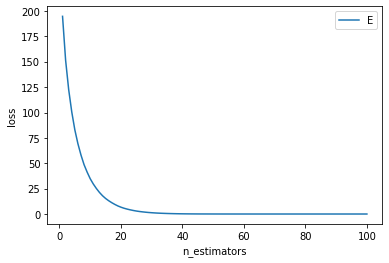

In [29]:
ax = plt.gca()
ax.plot(np.arange(model.n_estimators) + 1, model.train_score_)
ax.set_xlabel('n_estimators')
ax.set_ylabel('loss')
plt.legend('Error vs n_estimators');

# loss drops to 0.1012 ie. accuracy = 0.9

In [15]:
def get_val_score(X_test,y_test,model,batch_size=128):
    accuracy=[]
    num_samples = len(X_test)
    for offset in range(0, num_samples, batch_size):
        # Samples use in this batch
        X_samples = X_test[offset:offset+batch_size]
        y_samples = y_test[offset:offset+batch_size] 
        # Initialise batch arrays for this batch
        X_batch = []
        
        # For each samples
        for batch_sample in X_samples:
            image = image_transform(batch_sample)
            image = np.array(image)
            # Add example to arrays
            X_batch.append(image)
        accuracy.append(accuracy_score(y_samples,model.predict(X_batch)))
    return accuracy

In [17]:
test_acc=get_val_score(X_test,y_test,model,batch_size=128)

In [30]:
np.mean(np.mean(test_acc))
# accuracy is only 0.18

0.17878705431177447

## Feature Importance

In [167]:
feature=model.feature_importances_

In [168]:
feature=feature.reshape(256,256)

In [169]:
# max radius will be 5 for the feature
feature=feature/feature.max()*5

In [170]:
feature>1

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [171]:
x,y=np.nonzero(feature>1)

In [172]:
# the circle in the image later will be 
radius=feature[feature>1]

In [173]:
img_34=skio.imread('imgs\\train\\c0\\img_34.jpg',as_gray=True)

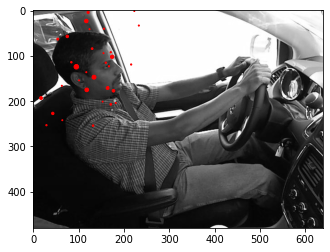

In [182]:
fig, ax = plt.subplots()
ax.imshow(img_34,cmap='gray')
for i in range(len(radius)):
    ax.add_patch(plt.Circle((x[i],y[i]),radius[i],color='r'))
plt.show()

## Kaggle Submission

In [ ]:
len(glob.glob('imgs\\test\\test\\*.jpg'))

In [ ]:
X_batch=pd.DataFrame()
for i in range(0, 79726, 128):
        # Samples use in this batch
        X_samples = glob.glob('imgs\\test\\test\\*.jpg')[i:i+128]
        # Initialise batch arrays for this batch
        X_array_for_prediction = []
 
        # For each sample
        for batch_sample in X_samples:
            image = image_transform(batch_sample)
            X_array_for_prediction.append(image)
        # Add sample to arrays
        data=pd.DataFrame(model.predict_proba(X_array_for_prediction))
        X_batch=X_batch.append(data)

In [ ]:
index=pd.Series([i.split('\\')[-1] for i in glob.glob('imgs\\test\\test\\*.jpg')],name='img')

In [ ]:
X_batch.index=index

In [ ]:
X_batch

In [ ]:
X_batch.columns=['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']

In [ ]:
X_batch.to_csv('ensemble.csv')

![](assets/ensemble.png)

## Evaluation

The model did not work as well as intended due the mostly the fact that the angle that the drivers are driving has slight differences and it does not really consider the hand positions as i would like it to. However, we can see how the head positions are captured in this model with the feature importance. Either way this method is high prone to be affected by the skin colour of the individual and the amount of light exposure since the mask created is using dark spots in the image. While this method might not be correct. We could try other methods such as bounding boxes or guassian mixtures or other transformation of image instead of background removal.